In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

$$g_j = e^{jpx} cos (2\pi j qx) $$

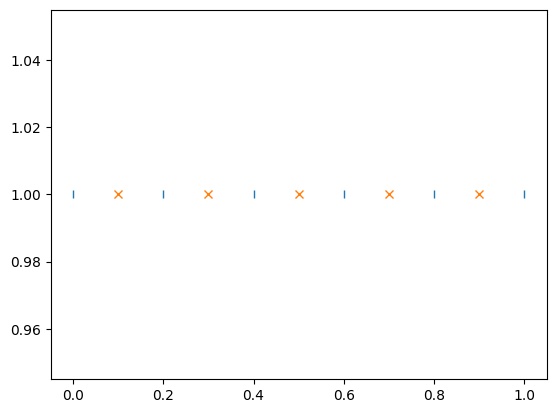

In [2]:
M = 5
x_node = np.linspace(0, 1, M+1)
x_center = (x_node[:-1] + x_node[1:]) * 0.5
plt.plot(x_node, np.ones(M+1), '|')
plt.plot(x_center, np.ones(M), 'x')

In [3]:
M = 5
N = 30
p = -0.05
q = 0.1
j = 0
g_j = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)

In [4]:
data = np.ones((2, M+1))*0.5
data

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [5]:
M = 100
N = 30
p = -0.05
q = 0.1
x_node = np.linspace(0, 1, M+1)
x_center = (x_node[1:] + x_node[:-1]) * 0.5
G_node = np.zeros((M+1, N))
for j in range(0, N):
    G_node[:,j] = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)
dx = np.diff(x_node)    
Av = sp.spdiags(np.ones((2, M+1))*0.5, [0, 1], M, M+1)
dx_diag = sp.spdiags(dx, [0], M, M)
G = G_node.T @ Av.T @  dx_diag 

In [6]:
def get_G_matrix(M, N, p, q):
    """
    Comments
    """
    x_node = np.linspace(0, 1, M+1)
    x_center = (x_node[1:] + x_node[:-1]) * 0.5
    G_node = np.zeros((M+1, N))
    for j in range(0, N):
        G_node[:,j] = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)
    dx = np.diff(x_node)    
    Av = sp.spdiags(np.ones((2, M+1))*0.5, [0, 1], M, M+1)
    dx_diag = sp.spdiags(dx, [0], M, M)
    G = G_node.T @ Av.T @  dx_diag     
    return G, x_center

In [23]:
M = 100
N = 30
p = -0.1
q = 0.15
G, x_center = get_G_matrix(M, N, p, q)
m = np.zeros(M)
box_index = np.logical_and(x_center>0.2, x_center<0.4)
m[box_index] = 1.
dpred = G @ m 

(1.0, 30.0)

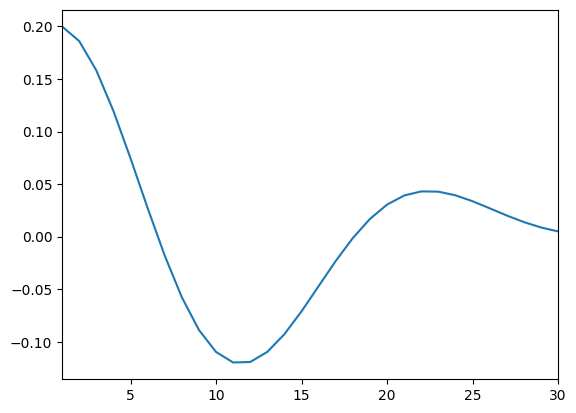

In [24]:
plt.plot(np.arange(N)+1, dpred)
plt.xlim(1, N)

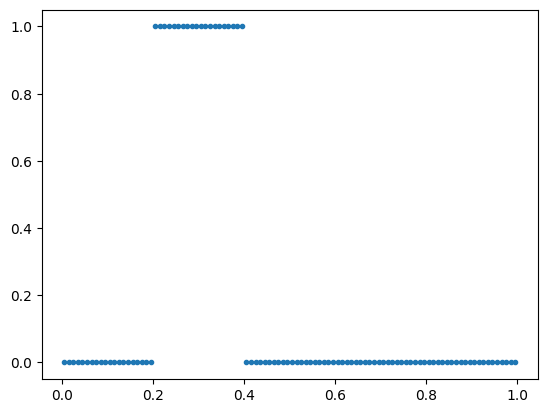

In [25]:
plt.plot(x_center, m, '.')

In [26]:
# i_column = 30
# out = plt.plot(x_center, G.T[:,:i_column])

In [27]:
G.shape

(30, 100)

In [28]:
e = np.ones((20, 10))

In [29]:
vec = np.arange(10)
vec

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
# plt.plot(x_node, G_node.T)

# Let's invert

In [31]:
dpred = G@m
dobs = dpred.copy()

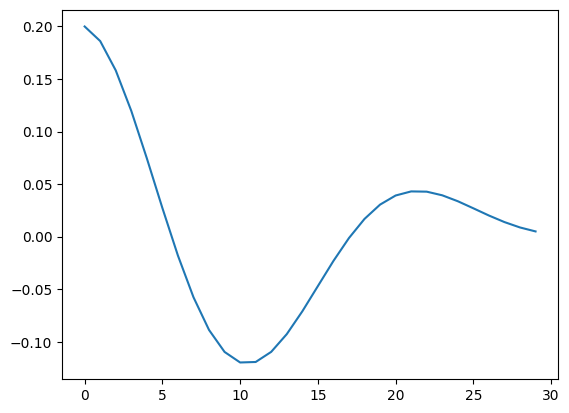

In [32]:
plt.plot(dpred)

In [35]:
m_est = np.linalg.solve(G.T @ G, G.T @ dpred)

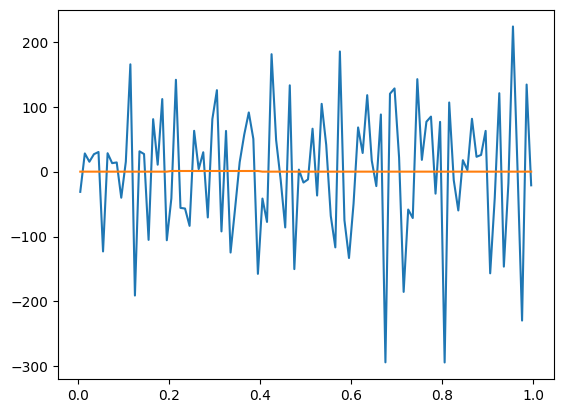

In [36]:
plt.plot(x_center, m_est)
plt.plot(x_center, m)

## It does not work just with the data

## Let's add a regularization term

In [37]:
phi_m = np.linalg.norm(m)**2

In [38]:
M = 100

In [40]:
h = np.diff(x_node)
Ws = sp.spdiags(np.ones(M) * np.sqrt(h), [0], M, M)
e = np.ones(M)
Av = sp.spdiags(np.ones((2, M+1))*0.5, [0, 1], M, M+1)
Wx = sp.spdiags(np.vstack((-e/h, e/h)) * np.sqrt(h), [0, 1], M-1, M)
alpha_s = 1./h[0]**2
alpha_x = 1

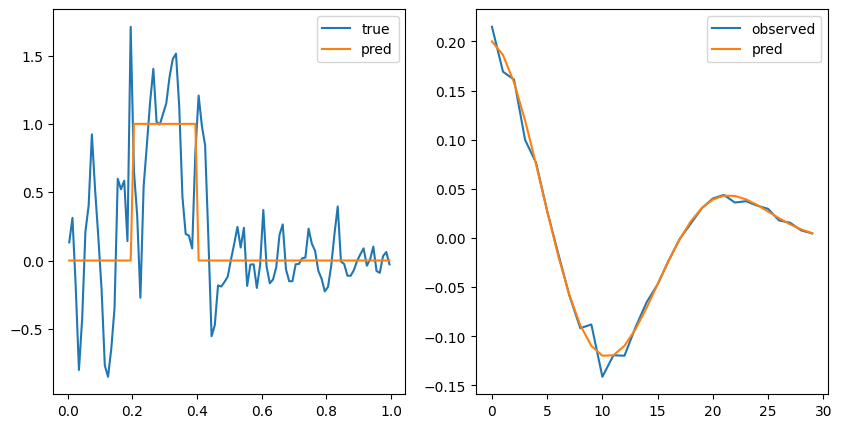

In [67]:
beta = 3e-14
rerr = 0.1
noise = np.random.randn(len(dpred)) * abs(dpred) * rerr
dobs = dpred.copy() + noise

data_std = rerr * abs(dobs)

Wd = sp.spdiags(1./data_std, [0], N, N)
m_est_reg = np.linalg.solve(G.T @ Wd.T @ Wd @ G + beta*alpha_s*(Ws.T@ Ws) + beta*alpha_x*(Wx.T@ Wx), G.T @ Wd.T @ Wd @ dpred)

fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
ax1.plot(x_center, m_est_reg, label='true')
ax1.plot(x_center, m, label='pred')

ax2.plot(dobs, label='observed')
ax2.plot(G@m_est_reg, label='pred')
for ax in axs:
    ax.legend()

In [73]:
betas = np.logspace(-15, 2, 100)
phi_ds = []
phi_ms = []
for beta in betas:
    m_est_reg = np.linalg.solve(G.T @ Wd.T @ Wd @ G + beta*alpha_s*(Ws.T@ Ws) + beta*alpha_x*(Wx.T@ Wx), G.T @ Wd.T @ Wd @ dpred)
    phi_d = np.linalg.norm(Wd @ (G@m_est_reg - dobs))**2
    phi_m = beta * alpha_s * np.linalg.norm(Ws@m_est_reg)**2 + beta * alpha_x * np.linalg.norm(Wx@m_est_reg)**2
    phi_ds.append(phi_d)
    phi_ms.append(phi_m)

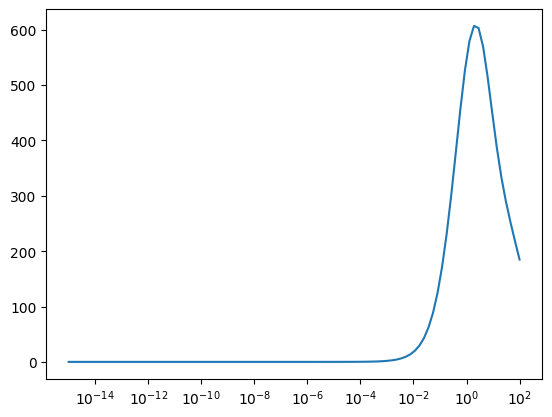

In [79]:
plt.semilogx(betas, phi_ms)

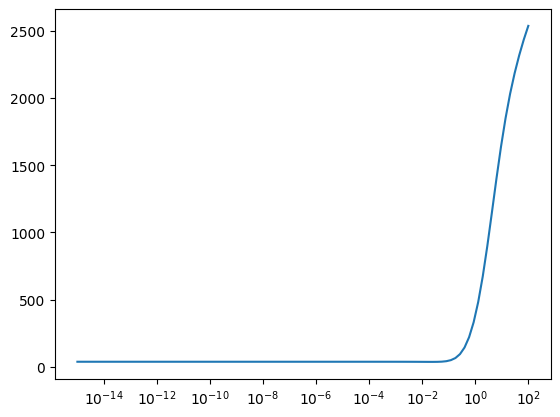

In [78]:
plt.semilogx(betas, phi_ds)

In [76]:
betas

array([1.00000000e-15, 1.48496826e-15, 2.20513074e-15, 3.27454916e-15,
       4.86260158e-15, 7.22080902e-15, 1.07226722e-14, 1.59228279e-14,
       2.36448941e-14, 3.51119173e-14, 5.21400829e-14, 7.74263683e-14,
       1.14975700e-13, 1.70735265e-13, 2.53536449e-13, 3.76493581e-13,
       5.59081018e-13, 8.30217568e-13, 1.23284674e-12, 1.83073828e-12,
       2.71858824e-12, 4.03701726e-12, 5.99484250e-12, 8.90215085e-12,
       1.32194115e-11, 1.96304065e-11, 2.91505306e-11, 4.32876128e-11,
       6.42807312e-11, 9.54548457e-11, 1.41747416e-10, 2.10490414e-10,
       3.12571585e-10, 4.64158883e-10, 6.89261210e-10, 1.02353102e-09,
       1.51991108e-09, 2.25701972e-09, 3.35160265e-09, 4.97702356e-09,
       7.39072203e-09, 1.09749877e-08, 1.62975083e-08, 2.42012826e-08,
       3.59381366e-08, 5.33669923e-08, 7.92482898e-08, 1.17681195e-07,
       1.74752840e-07, 2.59502421e-07, 3.85352859e-07, 5.72236766e-07,
       8.49753436e-07, 1.26185688e-06, 1.87381742e-06, 2.78255940e-06,
      

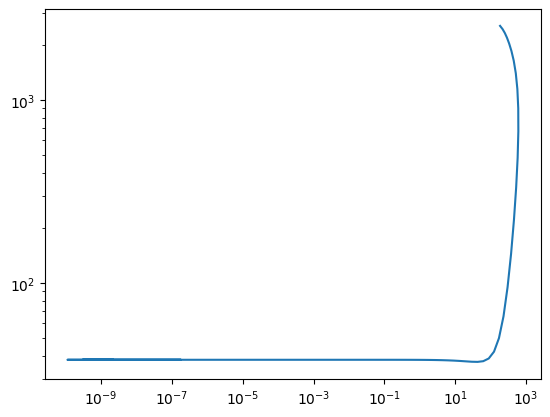

In [75]:
plt.loglog(phi_ms, phi_ds)